# Рассчет направлений изгиба спиралей при переходе из неактивного состояния в активное

In [1]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [108]:
data = pd.read_csv('GPCR-TM-table-directions.csv', index_col='index')
data.head()

,index.1,GPCR,Family,Class,Species,pdb_active,pdb_inactive,chain_a,chain_i,TM1_active,...,TM4_normed_angle,TM5_angle,TM5_norm,TM5_normed_angle,TM6_angle,TM6_norm,TM6_normed_angle,TM7_angle,TM7_norm,TM7_normed_angle
index,,,,,,,,,,,,,,,,,,,,,
0,0,5-HT2C receptor,5-Hydroxytryptamine receptors,Class A (Rhodopsin),Human,6bqg,6bqh,A,A,60-81,...,1.993910,-1.178967,4.782832,-1.178967,-1.250234,6.849923,-1.250234,2.345415,0.891099,NaN
1,1,M2 receptor,Acetylcholine receptors (muscarinic),Class A (Rhodopsin),Human,4mqs,3uon,A,A,19-51,...,-1.087460,0.700292,2.729190,0.700292,-1.510470,9.830663,-1.510470,2.095333,0.542182,NaN
2,2,M2 receptor,Acetylcholine receptors (muscarinic),Class A (Rhodopsin),Human,4mqt,3uon,A,A,19-51,...,-1.220777,0.721699,2.678625,0.721699,-1.543844,8.873740,-1.543844,2.486094,0.348299,NaN
3,3,A2A receptor,Adenosine receptors,Class A (Rhodopsin),Human,5g53,3eml,A,A,2-34,...,NaN,0.179357,8.431629,0.179357,-0.799123,10.429067,-0.799123,2.219558,2.536811,2.219558
4,4,A2A receptor,Adenosine receptors,Class A (Rhodopsin),Human,5g53,3pwh,A,A,2-34,...,NaN,-0.165341,9.037990,-0.165341,-1.193865,14.019750,-1.193865,2.176525,2.141956,2.176525


## Обработка данных
*Функция обрабатывает исходную базу и выдергивает из неё координаты проекций*

In [33]:
def get_X_Y(state, tm, position, data):
    name = 'TM' + str(tm) + '_' + state + '_bottom_' + position
    X = []
    Y = []
    
    for point in data[name]:
        X.append(float(point.split(', ')[0]))
        Y.append(float(point.split(', ')[1]))
        
    return np.array(X), np.array(Y)

## Вычисление углов: способ 1
**Углы считались по следующему алгоритму:**
1. Вычислить вектор, соединяющий проекции начала и конца спирали в неактивном состоянии.
2. Вычислить вектор, соединяющий проекции начала и конца спирали в активном состоянии.
3. Привести эти векторы в начало координат. *(Тут может быть косяк, потому что не факт, что проекции начала спиралей в активном и неактивном состоянии совпадают)*.
4. Вычислит разницу между вектором из **(2)** и вектором из **(1)**.
5. Угол между вектором **(1)** и вектором **(4)** задает направление перехода спрали из неактивного в активное состояния.

**Когда будем семплировать, алгоритм будет следующим:**
1. Вычисляем вектор, соединяющий проекции начала и конца спирали в неактивном состоянии.
2. Приводим вектор в начало координат.
3. Относительно направления, заданного вектором **(1)** строим коридор, основываясь на распределении углов.

In [36]:
def get_directions(tm):
    
    X_inactive_first, Y_inactive_first = get_X_Y('inactive', tm, 'first', data)
    X_inactive_last, Y_inactive_last = get_X_Y('inactive', tm, 'last', data)
    X_inactive_relative = X_inactive_last - X_inactive_first
    Y_inactive_relative = Y_inactive_last - Y_inactive_first
    inactive = np.array([np.array([coord[0], coord[1]]) for coord in zip(X_inactive_relative, Y_inactive_relative)])
    
    X_active_first, Y_active_first = get_X_Y('active', tm, 'first', data)
    X_active_last, Y_active_last = get_X_Y('active', tm, 'last', data)
    X_active_relative = X_active_last - X_active_first
    Y_active_relative = Y_active_last - Y_active_first
    active = np.array([np.array([coord[0], coord[1]]) for coord in zip(X_active_relative, Y_active_relative)])
    
    X_delta = X_active_relative - X_inactive_relative
    Y_delta = Y_active_relative - Y_inactive_relative
    deltas = np.array([np.array([coord[0], coord[1]]) for coord in zip(X_delta, Y_delta)])
    
    cos_angle = np.array([np.dot(t[0], t[1]) / np.linalg.norm(t[0]) / np.linalg.norm(t[1]) for t in zip(deltas, inactive)])
    cos_angle = np.arccos(cos_angle)
    dir_angle = np.array([np.sign(t[0][1] - t[0][0] * t[1][1] / t[1][0]) for t in zip (deltas, inactive)])
    angles = np.array([t[0] * t[1] for t in zip(dir_angle, cos_angle)])
    pylab.figure(1, figsize=(15, 5))
    pylab.subplot(121)
    pylab.hist(angles)
    pylab.title('direction angle in rad for TM ' + str(tm) + ' distribution')
    
    
    rot_angle = np.array([np.arccos(t[0] / np.linalg.norm(t)) * np.sign(t[1]) * (-1) for t in inactive])
    rotated_deltas = np.array([np.dot(np.array([[np.cos(t[0]), (-1) * np.sin(t[0])], [(-1) * np.sin(t[0]), (-1) * np.cos(t[0])]]), t[1]) for t in zip(rot_angle, deltas)])

    rotated_deltas_X = np.array([t[0] for t in rotated_deltas])
    rotated_deltas_Y = np.array([t[1] for t in rotated_deltas])

    pylab.subplot(122)
    pylab.scatter(rotated_deltas_X, rotated_deltas_Y)
    pylab.title('Bend direction for TM ' + str(tm) + ' in coordinats')
    
    data['TM' + str(tm) + '_angle'] = angles

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


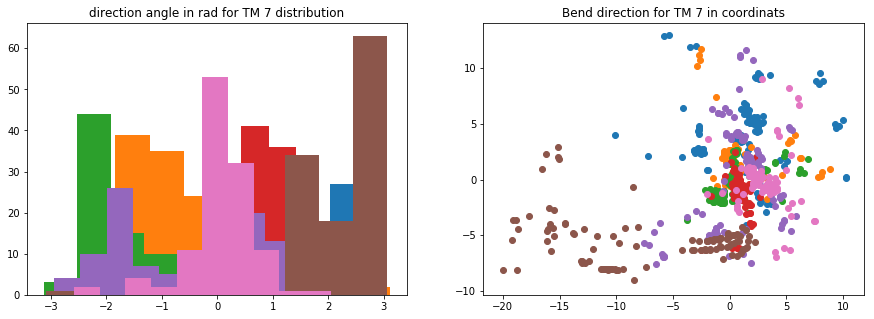

In [130]:
for i in range (1, 8):
    get_directions(i)

## Вычисление углов: способ 2
**Углы считались по следующему алгоритму:**
1. Вычислить вектор, соединяющий проекции начала (или конца) спирали в неактивном состоянии с началом (или концом) спирали в активном состоянии. Что выбирать, начало или конец, зависит от того, где отклонение больше.
2. TM1 - начало, TM2 - конец, TM3 - конец, TM4 - конец, TM5 - конец, TM6 - начало, TM7 - конец.
3. Угол между вектором **(1)** и осью **x** задает направление перехода спрали из неактивного в активное состояния.
4. Модуль вектора **(1)** характеризует амплитуду перехода из неактивного состояния в активное.
5. Если построить вектор в координатах плоскости мембраны, получим сектор, отвечающий переходу спирали из неактивного в активное состояния.

**Когда будем семплировать, алгоритм будет следующим:**
1. Вращаем вектор, соединяющий точку изгиба и конец (или начало, в зависимости от того, какая часть спирали гнется) так, чтобы он попадал в определенный выше сектор. Таким образом, ветор будет описывать конус. Семплировать будем по радиусу конуса и углу между направляющей и ветором.

In [38]:
def get_directions_2(tm, position):
    X_inact_first, Y_inact_first = get_X_Y(position=position, state='inactive', tm=tm, data=data)
    X_act_first, Y_act_first = get_X_Y(position=position, state='active', tm=tm, data=data)

    X_delta = X_act_first - X_inact_first
    Y_delta = Y_act_first - Y_inact_first
    delta = np.array([np.array([t[0], t[1]]) for t in zip(X_delta, Y_delta)])

    angles = np.array([np.arccos(t[0] / np.linalg.norm(t)) * np.sign(t[1]) for t in delta])
    norms = np.array([np.linalg.norm(t) for t in delta])
    normed_angle = np.array([t[0] for t in zip(angles, norms) if t[1] > 1])
    
    data['TM' + str(tm) + '_angle'] = angles
    data['TM' + str(tm) + '_norm'] = norms
    
    for idx in data.index:
        if data['TM' + str(tm) + '_norm'][idx] > 1:
            data['TM' + str(tm) + '_normed_angle'][idx] = data['TM' + str(tm) + '_angle'][idx]
    

    pylab.figure(tm, figsize=(15, 9))
    pylab.subplot(221)
    pylab.hist(angles)
    pylab.title('direction angle in rad for TM ' + str(tm) + ' distribution')
    
    pylab.subplot(222)
    pylab.hist(norms)
    pylab.title('Bend norms for TM ' + str(tm) + ' distribution')
    
    pylab.subplot(223)
    pylab.hist(normed_angle)
    pylab.title('Bend angles where bend norm > 1 for TM ' + str(tm) + ' distribution')
    
    pylab.subplot(224)
    pylab.scatter(X_delta, Y_delta)
    pylab.title('Bend direction for TM ' + str(tm) + ' in coordinats')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


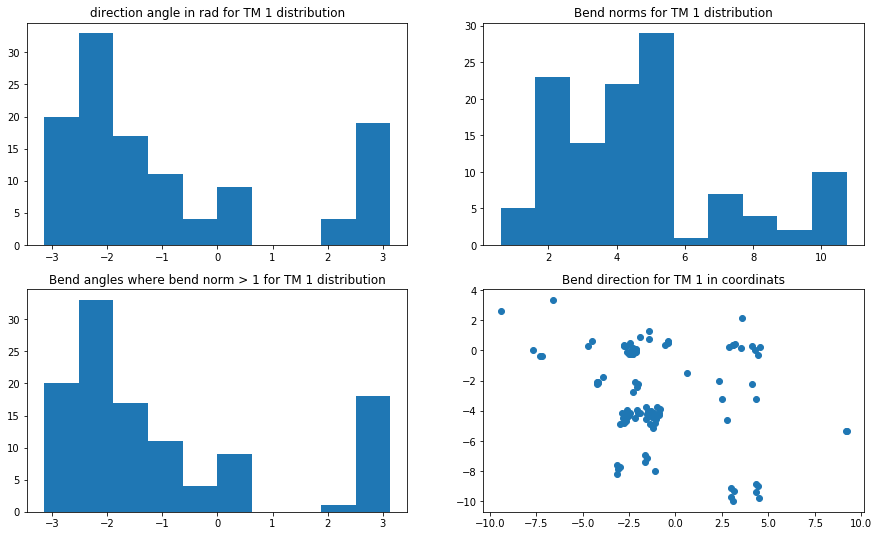

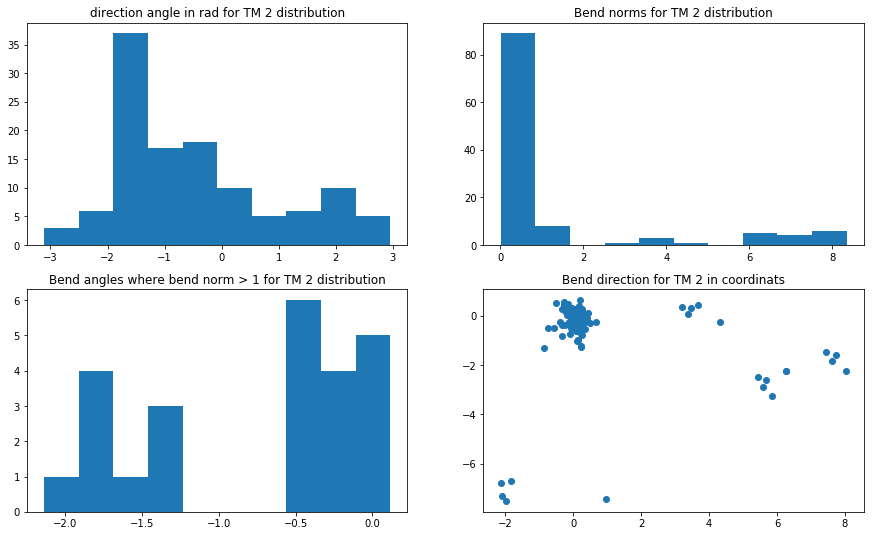

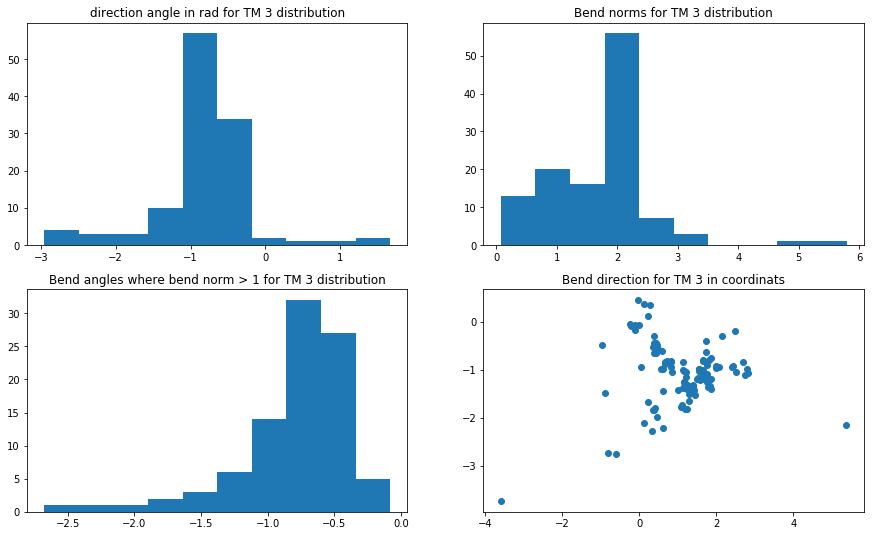

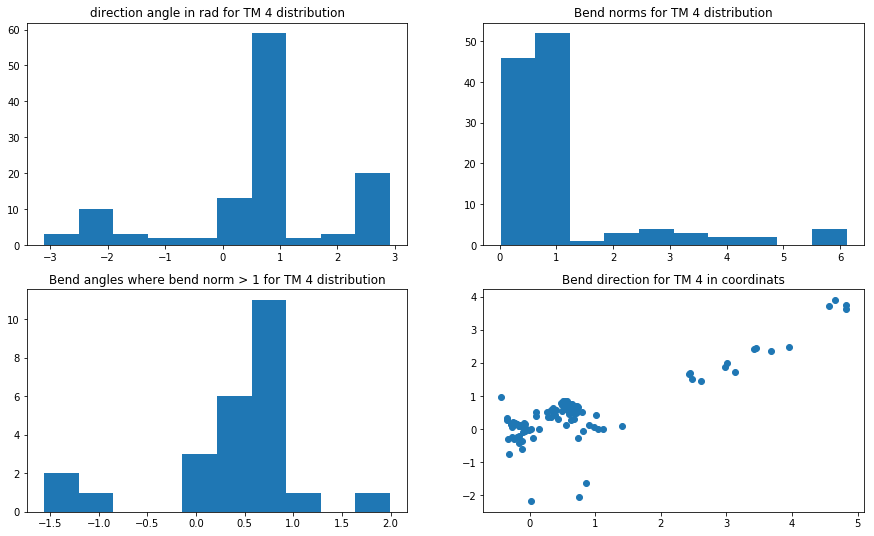

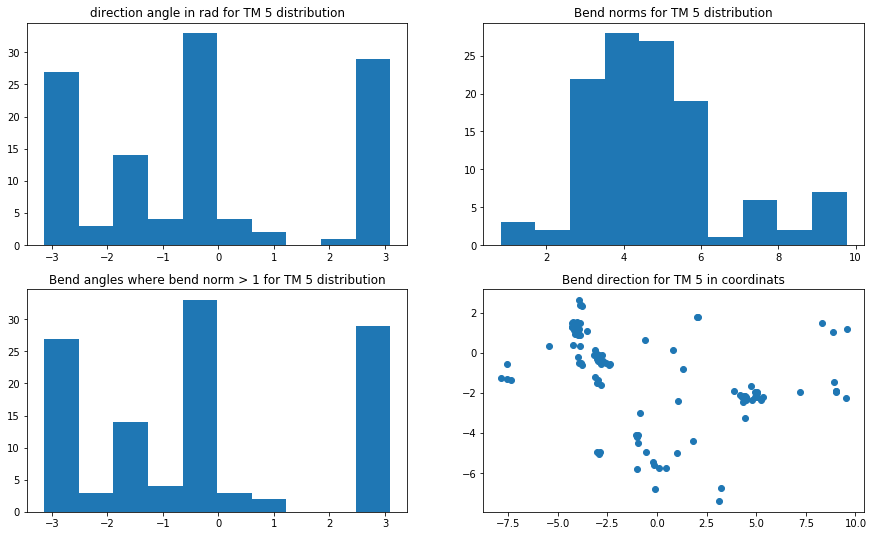

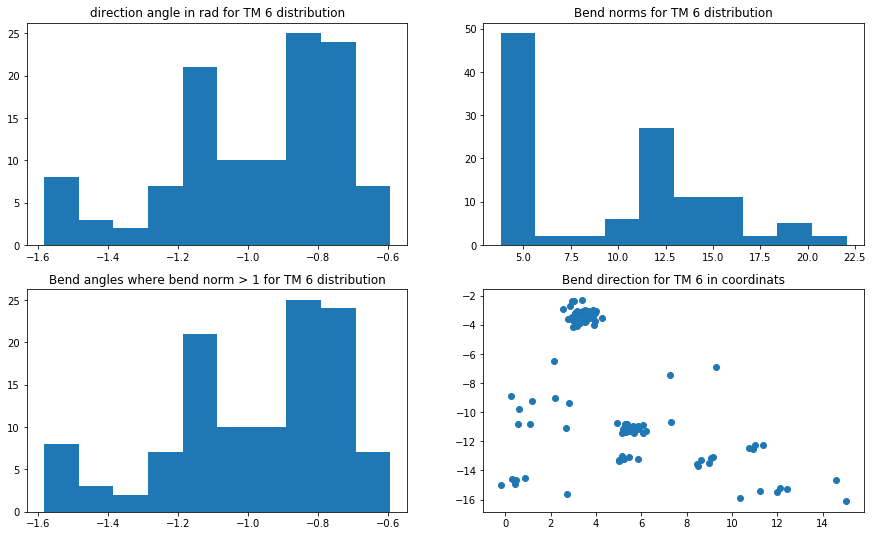

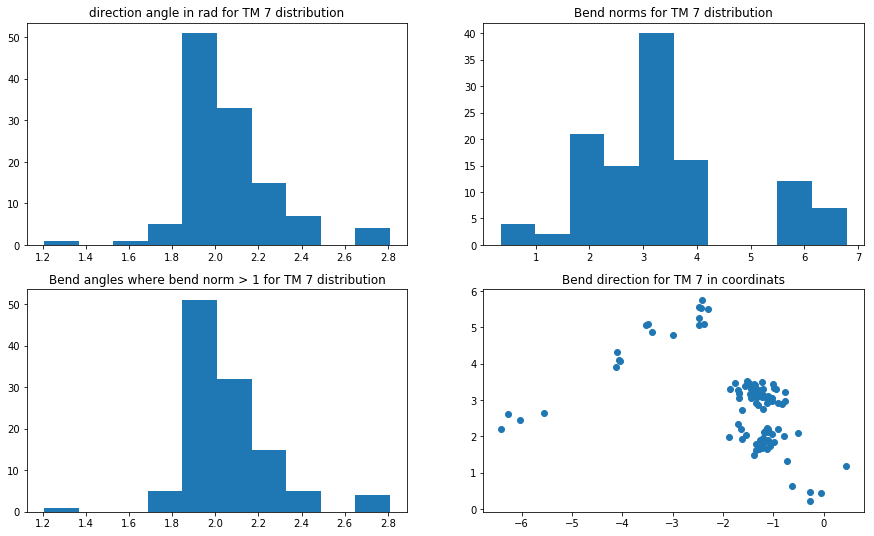

In [24]:
for tm in range(1, 8):
    if tm == 1 or tm == 6:
        position = 'first'
    else:
        position = 'last'
        
    get_directions_2(tm, position)


## Строим результаты группируя их по семьям

In [83]:
def family_plot(tm):

    if tm == 1 or tm == 6:
        position = 'first'
    else:
        position = 'last'
    
    families = np.unique(data['Family'])

    pylab.figure(1, figsize=(15, 20))

    pylab.subplot(411)
    for family in families:

        temp_data = data[data['Family'] == family]
        pylab.hist(x=temp_data['TM' + str(tm) + '_angle'], label=family)

    pylab.legend(families, loc='center left', bbox_to_anchor=(1, 0.5))
    pylab.title('angle distribution by families for TM ' + str(tm))
    
    pylab.subplot(412)
    for family in families:

        temp_data = data[data['Family'] == family]
        pylab.hist(x=temp_data['TM' + str(tm) + '_norm'], label=family)

    pylab.legend(families, loc='center left', bbox_to_anchor=(1, 0.5))
    pylab.title('bend norm distribution by families for TM ' + str(tm))  
    
    pylab.subplot(413)
    
    tmp_data = data.fillna(0)
    normed_data = tmp_data[tmp_data['TM' + str(tm) + '_normed_angle'] != 0]
    for family in families:

        temp_data = normed_data[normed_data['Family'] == family]
        normed_angle = temp_data['TM' + str(tm) + '_normed_angle']
        pylab.hist(x=normed_angle, label=family)
        

    pylab.legend(families, loc='center left', bbox_to_anchor=(1, 0.5))
    pylab.title('angles where bend norm > 1 distribution by families for TM ' + str(tm))
    
    pylab.subplot(414)
    for family in families:

        temp_data = data[data['Family'] == family]
        X_inact_first, Y_inact_first = get_X_Y(position=position, state='inactive', tm=tm, data=temp_data)
        X_act_first, Y_act_first = get_X_Y(position=position, state='active', tm=tm, data=temp_data)

        X_delta = X_act_first - X_inact_first
        Y_delta = Y_act_first - Y_inact_first
        pylab.scatter(x=X_delta, y=Y_delta, label=family)

    pylab.legend(families, loc='center left', bbox_to_anchor=(1, 0.5))
    pylab.title('bend direction for TM ' + str(tm) + ' in coordinats')  

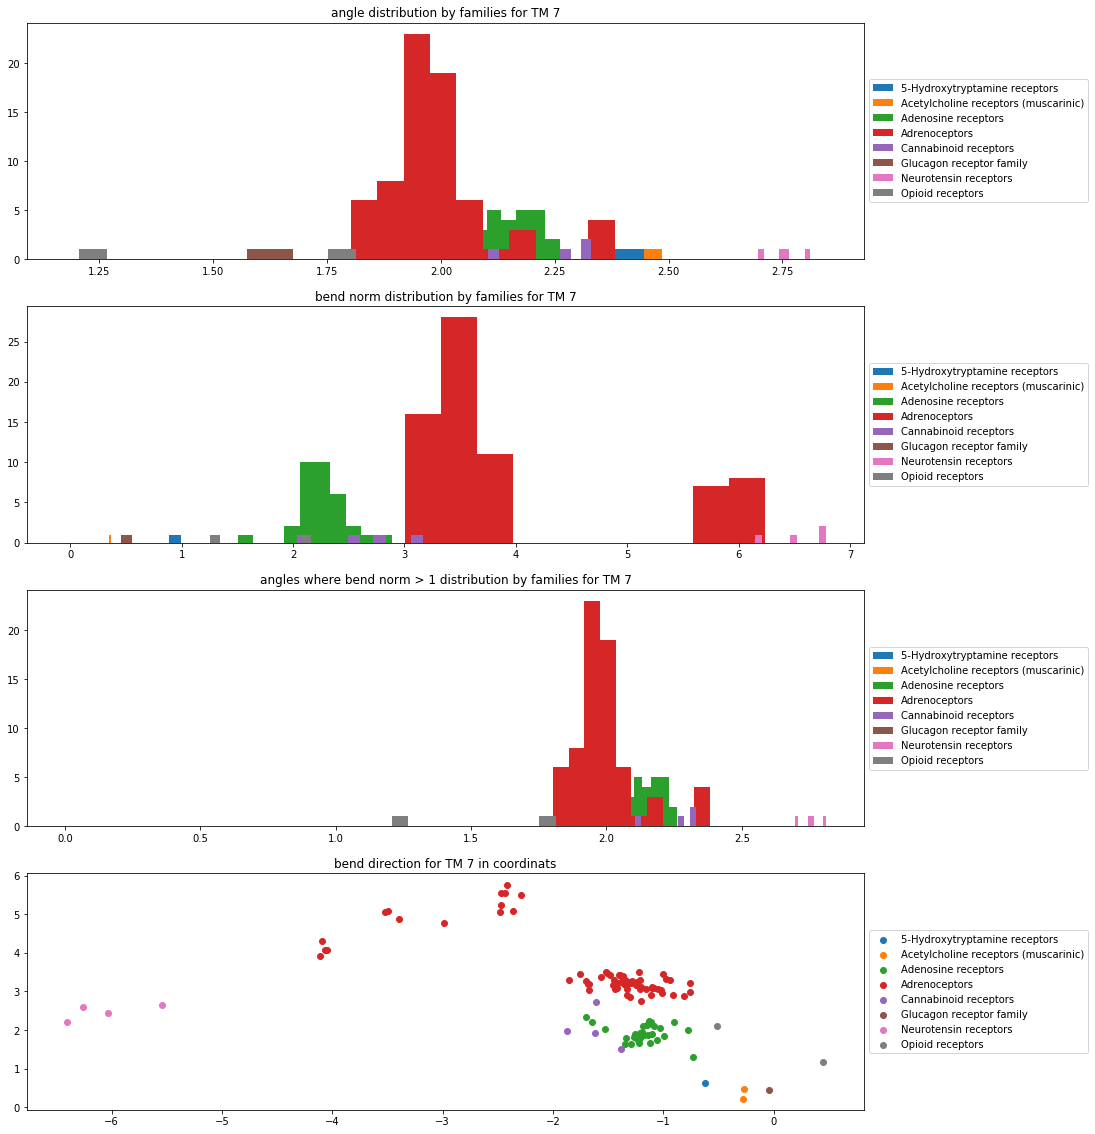

In [91]:
family_plot(7)
pylab.savefig('TM7.png', dpi=300)

In [92]:
data.to_csv('GPCR-TM-table-directions.csv', sep=',', index_label='index')